Read in all three of the data files.
Split the play in `midsummer.txt` up so each scene can be considered individually.

In [199]:
import re

# ------------------------------------
#               全局变量
# ------------------------------------

PLAY_FILE = 'midsummer.txt'
PLAY_FILE_ENCODING = 'UTF-8-Sig'
NEGATIVE_WORDS_FILE = 'negative-words.txt'
NEGATIVE_WORDS_FILE_ENCODING = 'cp1252'
POSITIVE_WORDS_FILE = 'positive-words.txt'
POSITIVE_WORDS_FILE_ENCODING = 'cp1252'

# ------------------------------------
#               剧本文字
# ------------------------------------

play_text = open(PLAY_FILE, encoding=PLAY_FILE_ENCODING).read()

# 每幕（ACT）包含两场（SCENE）
# 注意后续处理并不需要明确具体 ACT 以及 SCENE，故直接利用正则进行匹配
# 首先匹配每幕
acts_pat = re.compile(
    r'(?<=^ACT)(?:.*?\n)(.*?)(?=ACT|End of Project)', re.S | re.M)
acts_text = act_pat.findall(play_text)

# 两场戏剧文字匹配模式
scene1_pat = re.compile(r'(SCENE I.*?)(?=SCENE II)', re.S)
scene2_pat = re.compile(r'(SCENE II.*?\Z)', re.S)

# 将每幕中文字归到所有场次中去
scenes = []
for act in acts_text:
    scenes.append(scene1_pat.search(act).group())
    scenes.append(scene2_pat.search(act).group())

# ------------------------------------
#            积极、消极词汇
# ------------------------------------

pos_text = open(POSITIVE_WORDS_FILE,
                encoding=POSITIVE_WORDS_FILE_ENCODING).read()
neg_text = open(NEGATIVE_WORDS_FILE,
                encoding=NEGATIVE_WORDS_FILE_ENCODING).read()


def parseValidWords(s):
    """
    从文本中析出有效词语
    """

    words = []
    lines = s.splitlines()
    for line in lines:
        if line and not line.startswith(';'):
            words.append(line)
    return words


neg_words = parseValidWords(neg_text)
pos_words = parseValidWords(pos_text)

# ------------------------------------
#               粗略预览
# ------------------------------------

print('SCENES:')
for i, scene in enumerate(scenes[:4]):
    if i:
        print('-' * 50)
    print(scene[:100])
print('=' * 50)
print('POSITIVE WORDS:')
print('\t'.join(pos_words[:10]))
print('=' * 50)
print('NEGATIVE WORDS:')
print('\t'.join(neg_words[:10]))

SCENES:
SCENE I. Athens. A room in the Palace of THESEUS.

[Enter THESEUS, HIPPOLYTA, PHILOSTRATE, and Atten
--------------------------------------------------
SCENE II. The Same. A Room in a Cottage.

[Enter SNUG, BOTTOM, FLUTE, SNOUT, QUINCE, and STARVELING.
--------------------------------------------------
SCENE I. A wood near Athens.

[Enter a FAIRY at One door, and PUCK at another.]

PUCK
How now, spiri
--------------------------------------------------
SCENE II. Another part of the wood.

[Enter TITANIA, with her Train.]

TITANIA
Come, now a roundel a
POSITIVE WORDS:
a+	abound	abounds	abundance	abundant	accessable	accessible	acclaim	acclaimed	acclamation
NEGATIVE WORDS:
2-faced	2-faces	abnormal	abolish	abominable	abominably	abominate	abomination	abort	aborted


Develop a single measure based on the word occurrences that will describe the positivity/negativity of the scene.

In [200]:
# 编译积极、消极词汇正则，这里开启忽略大小写
pos_pat = re.compile('|'.join(map(re.escape, pos_words)), re.I)
neg_pat = re.compile('|'.join(map(re.escape, neg_words)), re.I)

# 所有场戏的积极消极词语数量统计
scene_emotions = []
for scene in scenes:
    pos_cnt = len(pos_pat.findall(scene))
    neg_cnt = len(neg_pat.findall(scene))
    scene_emotions.append((pos_cnt, neg_cnt))

print(scene_emotions)

[(165, 154), (41, 60), (136, 174), (85, 109), (115, 122), (215, 354), (128, 111), (17, 20), (179, 246), (26, 41)]


这里指定一个简单的策略：对于一场戏中出现的积极、消极词语出现的次数数组（积极词数，消极词数），计算其均值数，如果：
- 积极词数高于均值数的一个百分比（比如 5%），那就说这场戏是积极的；
- 消极词数高于均值数的一个百分比（比如 5%），那就说这场戏是消极的；
- 其他情况为情感中立的。

In [201]:
def judge_emotion(pairs, threshold=0.05):
    """
    判断给定情感词数元组代表的积极性与消极性
    """

    emo = ''
    mean = sum(pairs) / 2
    if pairs[0] > pairs[1] and pairs[0] / mean - 1 > threshold:
        emo = 'Positive'
    elif pairs[0] < pairs[1] and pairs[1] / mean - 1 > threshold:
        emo = 'Negative'
    else:
        emo = 'Neutral'

    return emo


for p in scene_emotions:
    print('{} ==> {}'.format(p, judge_emotion(p)))

(165, 154) ==> Neutral
(41, 60) ==> Negative
(136, 174) ==> Negative
(85, 109) ==> Negative
(115, 122) ==> Neutral
(215, 354) ==> Negative
(128, 111) ==> Positive
(17, 20) ==> Negative
(179, 246) ==> Negative
(26, 41) ==> Negative


可以看出在 `情感因子` 为 5% 时，这 10 场戏中很少有积极的戏（仅 1 场）

Make a plot of the measure as a y-axis, with scene number as an x-axis.

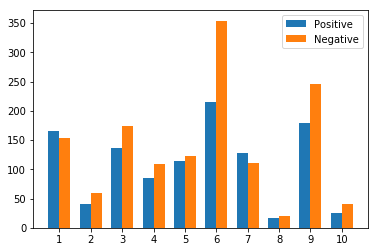

In [202]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 参考：
# https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html
# https://python-graph-gallery.com/10-barplot-with-number-of-observation

scene_emotions_pos = [x[0] for x in scene_emotions]
scene_emotions_neg = [x[1] for x in scene_emotions]

ind = np.arange(1, len(scenes)+1)
width = 0.35

plt.bar(ind - width / 2, scene_emotions_pos, width, label='Positive')
plt.bar(ind + width / 2, scene_emotions_neg, width, label='Negative')
plt.xticks(ind)
plt.grid(False)
plt.legend()
plt.show()

When a character starts speaking, their name appears in capitals, on its own line. Which character(s) speak most often?

In [203]:
from collections import defaultdict

# 全部戏剧正文文本
play_content = '\n'.join(scenes)

# 人名匹配规则
name_pat = re.compile(r'^[A-Z]+$', re.M)

# 匹配所有人名
characters = name_pat.findall(play_content)

# 人物出现次数列表
characters_dct = defaultdict(int)
for c in characters:
    characters_dct[c] += 1

sorted_characters = sorted(characters_dct.items(), key=lambda kv: kv[1], reverse=True)
for k, v in sorted_characters[:10]:
    print('"{}" appears {} times.'.format(k, v))


"LYSANDER" appears 50 times.
"THESEUS" appears 48 times.
"HERMIA" appears 48 times.
"DEMETRIUS" appears 47 times.
"BOTTOM" appears 47 times.
"QUINCE" appears 38 times.
"HELENA" appears 36 times.
"PUCK" appears 33 times.
"OBERON" appears 29 times.
"TITANIA" appears 23 times.


"Lysander" is a Talkaholic!

In [204]:
from jupyterthemes import jtplot
jtplot.reset()
# jtplot.style(theme='oceans16')